# Underfitting vs. Overfitting in Polynomial Regression

Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html

## Overview

This example demonstrates the problems of underfitting and overfitting and how we can use linear regression with polynomial features to approximate nonlinear functions. The plot shows the function that we want to approximate, which is a part of the cosine function. In addition, the samples from the real function and the approximations of different models are displayed. The models have polynomial features of different degrees. We can see that a linear function (polynomial with degree 1) is not sufficient to fit the training samples. This is called **underfitting**. A polynomial of degree 4 approximates the true function almost perfectly. However, for higher degrees the model will **overfit** the training data, i.e. it learns the noise of the training data.
We evaluate quantitatively **overfitting** / **underfitting** by using cross-validation. We calculate the mean squared error (MSE) on the validation set, the higher, the less likely the model generalizes correctly from the training data.

## Libraries

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.pipeline        import Pipeline
from sklearn.linear_model    import LinearRegression
from sklearn.preprocessing   import PolynomialFeatures

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics         import mean_squared_error

## 1. Polynomial regression

Polynomial actually is a form of linear regression, because the resulting model is linear in the parameters, $\beta_i$. The difference is that we change the features into polynomials of the input data $x_i$,
$$
\hat y_i = \beta_0 + \beta_1\, x_i + \beta_2\, x_i^2 + \beta_3\, x_i^3 + \dots
$$
or in matrix form
$$
\begin{bmatrix} \hat y_1 \\ \hat y_2 \\ \vdots \\ \hat y_n \end{bmatrix} =
\begin{bmatrix}
   1 & x_1 & x_1^2 & x_1^3 & \dots \\
   1 & x_2 & x_2^2 & x_2^3 & \dots \\
   \vdots \\
   1 & x_n & x_n^2 & x_n^3 & \dots 
\end{bmatrix}
\begin{bmatrix}
   \beta_0 \\
   \beta_1 \\
   \beta_2 \\
   \beta_3 \\
   \vdots
\end{bmatrix}.
$$
$$
\hat{\bf y} = {\bf X}\, \beta.
$$

The coefficients, $\beta_i$, that minimize the cost function are given by the mean-squared error, MSE, and fullfill the normal equation:
$$
{\bf X}^\mathrm{T} {\bf X}\, \beta = {\bf X}^\mathrm{T}\, {\bf y}.
$$

### 1.1 Generate data

In [2]:
# Use a module to define the reference function used to generate the data
def reference_function(X):
    return np.cos(1.5 * np.pi * X)

# Define seed for reproducibility
np.random.seed(0)

# Define the number of samples and degrees for the polynomial
number_of_samples = 30
polynomial_degree = np.array([1, 4, 15])

# Generate random data for fitting
X = np.sort( np.random.rand(number_of_samples) )
y = reference_function(X) + 0.1*np.random.randn(number_of_samples)

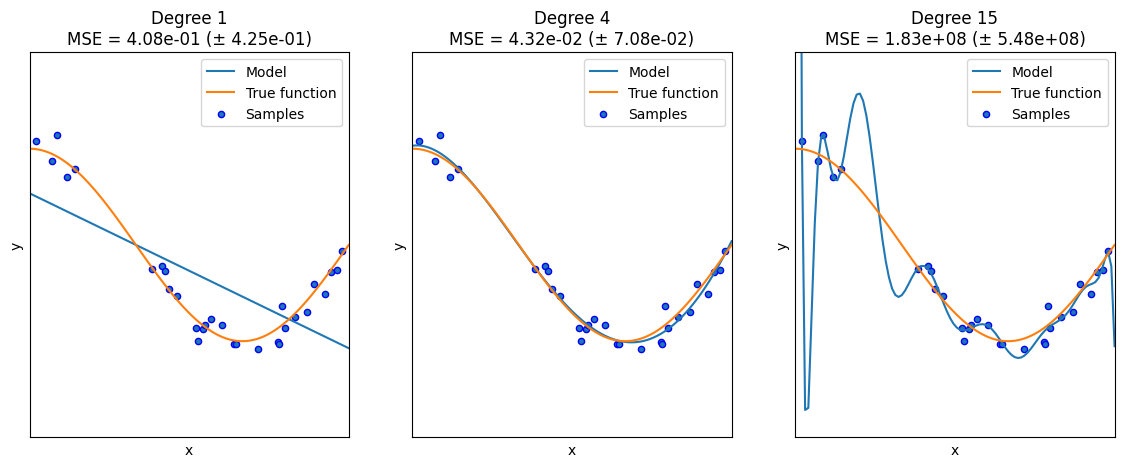

In [3]:
plt.figure( figsize=(14,5) )

for i in range(polynomial_degree.size):

    ax = plt.subplot(1, polynomial_degree.size, i+1)

    plt.setp( ax, xticks=(), yticks=() )

    plt.xlabel("x")
    plt.ylabel("y")

    plt.xlim( ( 0, 1) )
    plt.ylim( (-2, 2) )

    polynomial_features = PolynomialFeatures(degree=polynomial_degree[i], include_bias=False)
    linear_regression   = LinearRegression()

    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )

    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using cross-validation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)

    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")

    plt.plot(X_test, reference_function(X_test), label="True function")

    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")

    plt.title(f"Degree {polynomial_degree[i]}\n"
              f"MSE = {-scores.mean():.2e} (± {scores.std():.2e})")
    
    plt.legend(loc="best")

plt.show()

## 2. k-Fold cross validation

### Training and Testing Data
- Generally, we split data into training and testing sets.
- The training set is used to optimize the parameters of the model.
- The testing data is used to estimate the accuracy of the model on unseen data. 

### Validation Data
- Some models do not have sufficient flexibility to approximate the training data. These models have a high bias. They often perform similarly in the training and testing data.

- Sometimes models train well and have small loss on the training data, but perform poorly when presented with new data outside the training set. In this case the model has small bias but a large variance. This is known as overfitting to the training data.

- Many machine learning models have parameters that control their flexibility. An example is polynomial regression, where the order of the polynomial degree controls the flexibility and, hence, bias of the model.

- However, to decide what level of complexity is optimal for the machine learning model, we cannot use just the training data alone. We also cannot use the testing data as this would compromise its independence for estimating the accuracy of the model.

- Instead, we split data into a training and validation sets, where the training set is used to optimize the parameters of the model and the validation set then is used to compare between different models.

- In particular, k-fold cross validation is a technique for model selection where the training data set is divided into $k$ equal groups. The first group is considered as the validation set and the rest $k-1$ groups as training data, and the model is fit on it. This process is iteratively repeated $k-1$ times. Each time the $k^\mathrm{th}$ group will be selected as validation and the remaining $k-1$ groups be used for optimizing the model parameters, $\beta$. In each iteration, the validation MSE is calculated and the final MSE after $k$ iterations the Cross-Validation MSE is given as the average:
$$
\text{CV}_k = \frac{1}{N_k} \sum_{i=1}^k \text{MSE}_i
$$
This validation MSE is the estimate for our test data MSE.

<img src="https://github.com/rhennig/EMA6938/blob/main/Notebooks/Figures/Cross-Validation.png?raw=1" alt="Validation folds" align="center" style="width:400px; float:center"/>

Importantly, **cross-validation is for model selection or hyperparameter optimization** and utilizes the training data. To measure the **performance of our model**, we need to apply it to data that was not used in the optimization of the hyperparameters or model parameters. Usually, we keep a fraction of 20% of the data aside as a **holdout test set** and use 80% of the data for the training set used in cross-validations. We measure the model performance of the optimized model on the holdout test set.

Let's use the `KFold` object from the scikit-learn library to illustrate the indexes for a dataset are split into training and testing

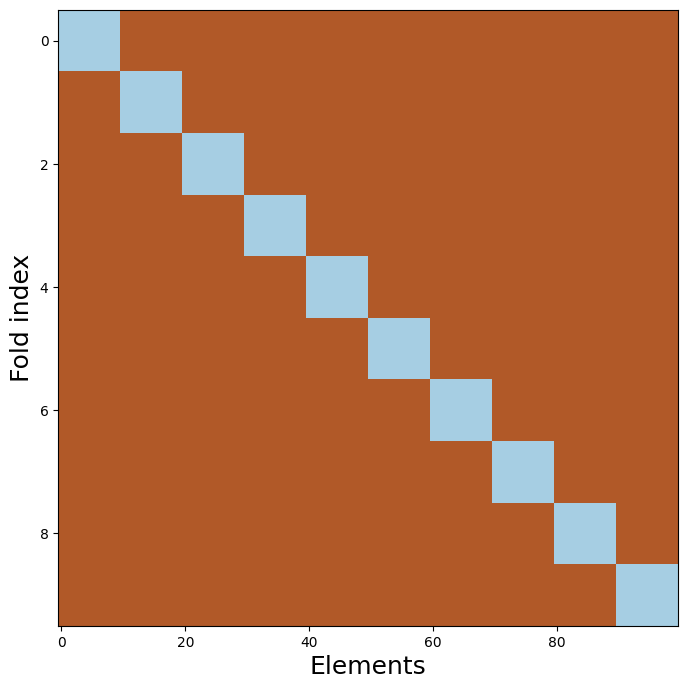

In [4]:
# Define a generic dataset
data_size = 100
k_folds   = 10

idx         = np.arange(data_size)
data_series = np.ones( (k_folds, data_size), dtype=float)

# Create the KFold object using 10 splits
k_folding = KFold(n_splits=k_folds)

for fold, (train, test) in enumerate( k_folding.split(idx) ):
    data_series[fold, test] = 0.0

# Plot the cross-validation indices for each fold
fig, ax = plt.subplots( figsize=(8,8) )

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

ax.set_xlabel('Elements',fontsize=18)
ax.set_ylabel('Fold index',fontsize=18)

plt.imshow(data_series, aspect='auto', cmap='Paired')

plt.show()

### 2.1 k-fold cross-validation in machine learning

In [5]:
# Define seed for reproducibility
np.random.seed(seed=0)

def reference_model(x, noise=False):

    y = np.cos(x) + 2.0*np.sin(x) + 3.0*np.cos(x*2)

    if noise:
        y = y + np.random.normal(0.0, 1.0, x.shape)

    return y

# Generate a reference data set without noise
x_ref = np.linspace(-0.3, 2.3, num=300)
y_ref = reference_model(x_ref, noise=False)

# Generate a data set with random noise
x = np.linspace(0.0, 2.0, num=300)
x = x + np.random.normal(0, 0.3, x.shape)

y = reference_model(x, noise=True)

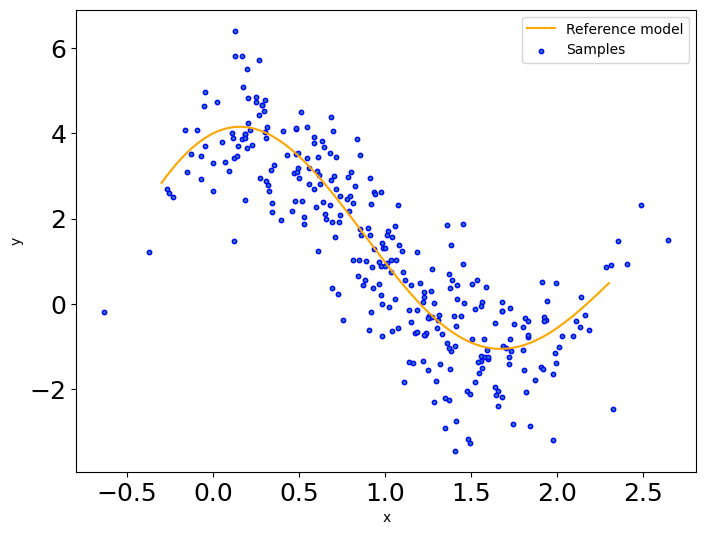

In [6]:
# Plot the  data set and the reference model

plt.figure( figsize=(8,6) )

plt.plot(x_ref, y_ref, color="orange", label="Reference model")
plt.scatter(x, y, edgecolor="b", s=10, label="Samples")

plt.xlabel("x")
plt.ylabel("y")

plt.legend(loc="best")

plt.show()

In [7]:
# Split the dataset into 80% for training and 20% for testing
x = x.reshape( (x.size,1) )
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

### 2.2 Select hyperparameters

First we need to evaluate the appropriate degree for the polynomial

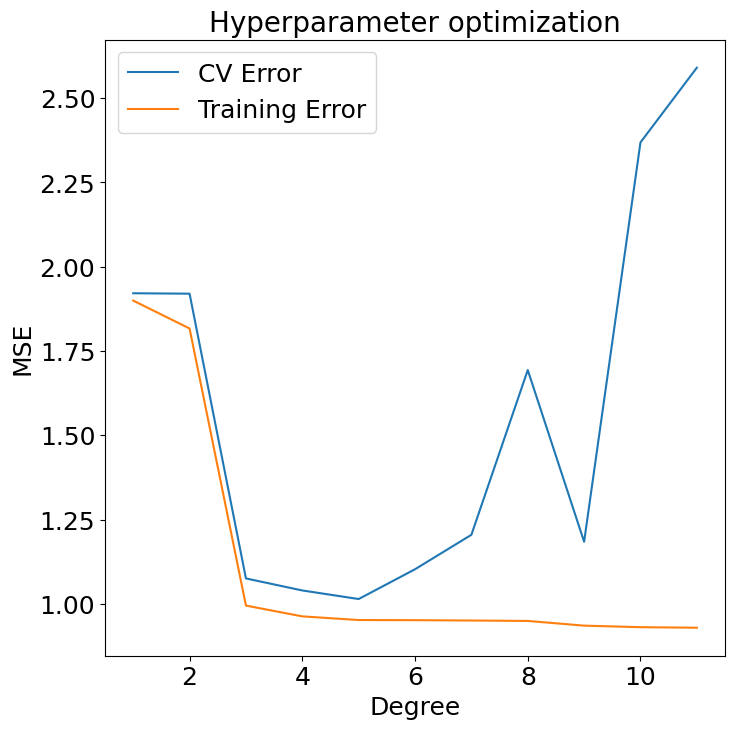

In [8]:
# Define the maximum degree of interest
polynomial_degrees = np.arange(start=1, stop=12, step=1)

# Define number of folds
number_of_folds    = 5

# Initialize empty lists to store the training and cross-validation errors
training_error_per_degree         = []
cross_validation_error_per_degree = []

for degree in polynomial_degrees:

    # Polynomial feature creation
    X = PolynomialFeatures(degree=degree).fit_transform(x_train)

    # Create regression model
    linear_regression = LinearRegression(fit_intercept=False)

    # Fit the model to the training data
    polynomial_model  = linear_regression.fit(X, y_train)

    y_train_pred      = polynomial_model.predict(X)

    training_mse      = mean_squared_error(y_train,y_train_pred)

    training_error_per_degree.append(training_mse)

    # Calculate the cross-validation MSE
    cross_validation_error = cross_validate(linear_regression, X, y_train,
                                            scoring='neg_mean_squared_error',
                                            cv=number_of_folds, return_train_score=True)

    mean_cross_validation_error = np.mean( np.absolute(cross_validation_error['test_score']) )

    cross_validation_error_per_degree.append(mean_cross_validation_error)

fig,ax=plt.subplots( figsize=(8,8) )

ax.set_xlabel('Degree', fontsize=18)
ax.set_ylabel('MSE',    fontsize=18)

ax.set_title('Hyperparameter optimization', fontsize=20)


ax.plot(polynomial_degrees, cross_validation_error_per_degree, label="CV Error")
ax.plot(polynomial_degrees, training_error_per_degree, label="Training Error")

ax.legend(loc='best', fontsize=18)

plt.show()

### 2.3 Validation with the holdout method

Now we use the best degree found in the previous section, then we train the model with the training set and validate it with the holdout set.

In [9]:
# Select the optimal hyperparameter
degree = np.argmin(cross_validation_error_per_degree) + 1
print(f"Optimal degree of polynomial regression = {degree}")

# Polynomial feature creation
X = PolynomialFeatures(degree=degree).fit_transform(x_train)

# Create regression model
linear_regression = LinearRegression(fit_intercept=False)

Optimal degree of polynomial regression = 5


In [10]:

# Fit the model to the training data
polynomial_model  = linear_regression.fit(X, y_train)

# Measure performance of optimal model on holdout dataset
X_test      = PolynomialFeatures(degree).fit_transform(x_test)

predicted_y = polynomial_model.predict(X_test)

mse_test    = mean_squared_error(y_test, predicted_y)

print(f"MSE on holdout set = {mse_test:.2f}")

# Calculate optimal polynomial regression
x_regression   = np.linspace(np.min(x), np.max(x), num=100)
x_regression_T = np.array([x_regression]).T
X_regression   = PolynomialFeatures(degree).fit_transform(x_regression_T)
y_model_pred   = linear_regression.predict(X_regression)

# Reference model
y_reference    = reference_model(x_regression, noise=False)

MSE on holdout set = 1.18


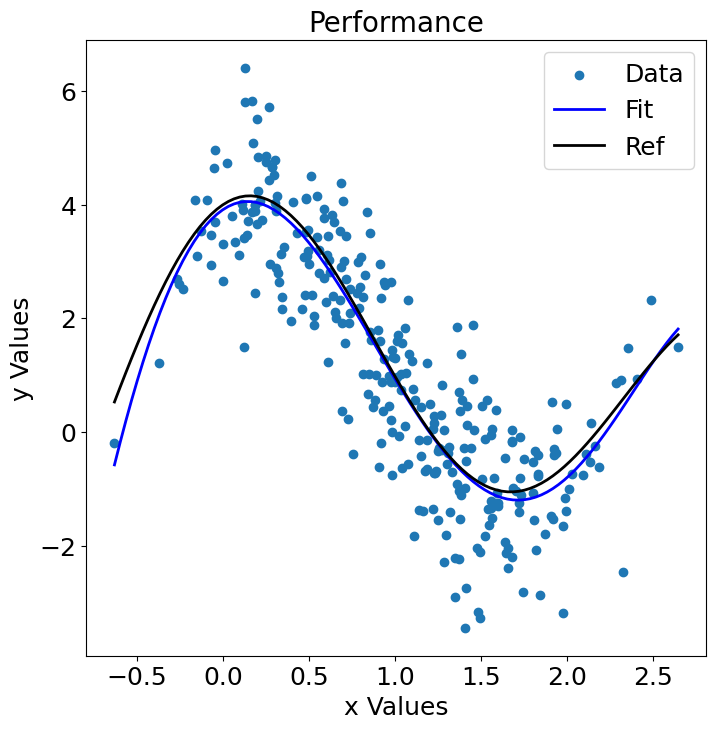

In [11]:

# Plot the whole dataset
fig, ax = plt.subplots( figsize=(8,8) )

ax.set_xlabel('x Values',   fontsize=18)
ax.set_ylabel('y Values',   fontsize=18)

ax.set_title('Performance', fontsize=20)

ax.scatter(x, y, label='Data')

ax.plot(x_regression, y_model_pred, color='b', label='Fit', lw=2)
ax.plot(x_regression, y_reference,  color='k', label='Ref', lw=2)

ax.legend(loc='best', fontsize=18)

plt.show()

> ### Assignment
>
> Visualize what happens when you set the degree of the polynomial to a one or a large number?

In [12]:
# Underfit model


# Overfit model


# Reference model


# Plot the whole dataset
